### Imports

In [1]:
import pickle
import winsound
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import layer
import copy
import math
from random import randint
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

### Set hiperparams

In [14]:
digits_nr = 10
epochs = 50
batch_size = 16
learning_rate = 0.005
layer_size = 128
hidden_layers = 2
augment_times = 4
stop_threshold = 4
init_type = "Default"
optimizer = "Default"

### Define functions

In [15]:
def load_mnist():
    print("Loading data...")
    mnist = fetch_openml('mnist_784', cache=False)
    print(mnist.__class__)
    x = mnist.data.astype('float32')
    y = mnist.target.astype('int64')
    x /= 255.0
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=17)
    assert (X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])
    print("Done")
    return X_train, X_test, y_train, y_test


def one_hot(y, output_size):
    t = np.array([np.zeros(output_size)]).T
    t[y] = 1
    return t


def check_loss(network, x_check_cost, y_check_cost):
    mean_loss = 0.0
    for i in range(x_check_cost.shape[0]):
        t = one_hot(y_check_cost[i], output_size=digits_nr)
        x = np.array([x_check_cost[i]]).T
        mean_loss += network.cost_fun(x, t)
    return round((mean_loss / x_check_cost.shape[0]).item(),6)


def pickle_mnist(file_name):
    print("Pickling MNIST...")
    mnist = fetch_openml('mnist_784', cache=False)
    pickling_on = open(file_name, "wb")
    pickle.dump(mnist, pickling_on)
    pickling_on.close()
    print("Pickling done")


def augment(X, y, img_shape, augment_times) -> (np.ndarray, np.ndarray):
    assert (X.shape[1] == img_shape[0] * img_shape[1])
    X_augmented = np.empty((X.shape[0] * augment_times, X.shape[1]))
    X_augmented[0:X.shape[0], :] = X
    y_augmented = np.empty((y.shape[0] * augment_times), dtype=int)
    y_augmented[0:y.shape[0]] = y
    X_arr = X.reshape(X.shape[0], img_shape[0], img_shape[1])
    for i in range(1, augment_times):
        X_aug_arr = seq.augment_images(X_arr)
        X_aug_vec = X_aug_arr.reshape(X_aug_arr.shape[0], img_shape[0] * img_shape[1])
        # X_augmented.append(X_aug_vec)
        # y_augmented.append(y)
        X_augmented[i * X.shape[0]: (i + 1) * X.shape[0], :] = X_aug_vec
        y_augmented[i * y.shape[0]: (i + 1) * y.shape[0]] = y
    return X_augmented, y_augmented


def unpickle_mnist(file_name, size):
    pickle_off = open(file_name, "rb")
    mnist = pickle.load(pickle_off)
    pickle_off.close()
    x = mnist.data.astype('float32')
    y = mnist.target.astype('int64')
    x /= 255.0
    X_train, X_test, y_train, y_test = train_test_split(x[0:size], y[0:size], test_size=0.20, random_state=17)
    assert (X_train.shape[0] + X_test.shape[0] == size)
    return X_train, X_test, y_train, y_test


def unpickle_full_mnist(file_name):
    pickle_off = open(file_name, "rb")
    mnist = pickle.load(pickle_off)
    pickle_off.close()
    x = mnist.data.astype('float32')
    y = mnist.target.astype('int64')
    x /= 255.0
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=17)
    return X_train, X_test, y_train, y_test


def confusion(network, X, y) -> (np.array, list):
    wrong_list = [[] for i in range(10)]
    y_pred = pd.Series(copy.copy(y), dtype=int, name="Predicted")  # copying y works as prealocation
    for i in range(X.shape[0]):
        x = np.array([X[i]]).T
        predicted = np.argmax(network.classify(x))
        y_pred.set_value(i, predicted)
    y_actu = pd.Series(y, name="Actual")
    wrong_pred_mask = y_actu != y_pred
    X_wrong = X[wrong_pred_mask]
    y_wrong = y_pred[wrong_pred_mask]
    for wrong in zip(y_wrong, X_wrong):
        wrong_list[wrong[0]].append(wrong[1].reshape(28, 28))
    return pd.crosstab(y_actu, y_pred), wrong_list



def check_accuracy(network, X_test, y_test):
    # Code duplication, yet it does not copy memory, hence it it's faster
    true_positive_counter = 0.0
    for i in range(X_test.shape[0]):
        x = np.array([X_test[i]]).T
        if np.argmax(network.classify(x)) == y_test[i]:
            true_positive_counter += 1
    return true_positive_counter / X_test.shape[0]


def pickle_network(network, file_name):
    print("Pickling Network...")
    pickling_on = open(file_name, "wb")
    pickle.dump(network, pickling_on)
    pickling_on.close()
    print("Pickling done")


def unpickle_network(file_name):
    pickle_off = open(file_name, "rb")
    net = pickle.load(pickle_off)
    pickle_off.close()
    return net

def plot_wrong(wrong_list):
    columns = 8
    fig_width = 8
    for digit in range(len(wrong_list)):
        rows = math.ceil(len(wrong_list[digit]) / columns)
        fig_height = fig_width * (rows / columns)
        fig = plt.figure(figsize=(fig_width, fig_height))
        fig.suptitle(f"Cyfry uznane za {digit}", fontsize=10)
        i = 1
        for image in wrong_list[digit]:
            fig.add_subplot(rows, columns, i)
            i += 1
            plt.imshow(image)
            plt.axis('off')
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.subplots_adjust(top=0.85)
        plt.show()

### Augmentation transformation

In [16]:
seq = iaa.Sequential([
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.85, 1.15), "y": (0.85, 1.15)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-8, 8),
        shear=(-3, 3)
    )
])

### Load network from pickle file

In [17]:
network = unpickle_network("Network Saves/network.pickle")

### Load data from pickle

In [18]:
X_train, X_test, y_train, y_test = unpickle_full_mnist("mnist.pickle")

### Init network

In [19]:
network = layer.Layer(hidden_layers=hidden_layers,
                      input_size=X_train.shape[1],
                      layer_size=layer_size,
                      output_size=digits_nr,
                      learning_rate=learning_rate,
                      init_type=init_type)

### Augment loaded train data

In [20]:
X_train, y_train = augment(X_train, y_train, (28, 28), augment_times)
winsound.Beep(2500, 100)

### Show sample augmented images

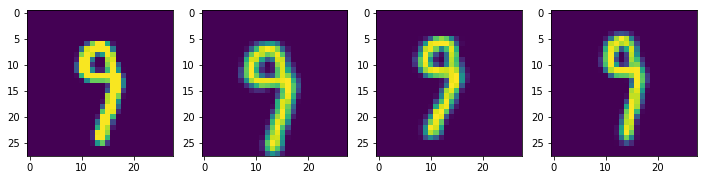

In [21]:
train_size = int(X_train.shape[0]/augment_times)
rand_pic = randint(0, train_size)
plt.subplots(1,4,figsize=(12,12))    
plt.subplot(141)
plt.imshow(X_train[rand_pic].reshape(28, 28))
plt.subplot(142)
plt.imshow(X_train[rand_pic+train_size].reshape(28, 28))
plt.subplot(143)
plt.imshow(X_train[rand_pic+2*train_size].reshape(28, 28))
plt.subplot(144)
plt.imshow(X_train[rand_pic+3*train_size].reshape(28, 28))
plt.show()

### Init other objects

In [10]:
train_loss_values = []
test_loss_values = []
accuracy = []
loss_values = []
prev_loss = float("inf")
loss_rise_count = 0
best_network = copy.deepcopy(network)

### Training loop

In [11]:
for epoch in range(epochs):
    print(f"epoch: {epoch + 1}/{epochs}",end=' ')
    for i in range(X_train.shape[0]):
        t = one_hot(y_train[i], output_size=digits_nr)
        x = np.array([X_train[i]]).T
        network.teach(x, t)
        if (i + 1) % batch_size == 0:
            network.apply_gradients(optimizer=optimizer)
    train_loss_values.append(check_loss(network, X_train, y_train))
    print(f"\ttrain loss:\t{check_loss(network, X_train, y_train)}", end='')
    print(f"\ttest loss: \t{check_loss(network, X_test, y_test)}")
    test_loss = check_loss(network, X_test, y_test)
    test_loss_values.append(test_loss)
    accuracy.append(check_accuracy(network, X_test, y_test))
    if prev_loss < test_loss:
        loss_rise_count += 1
        if loss_rise_count >= stop_threshold:
            print("\n-----------------------\nstop threashold reached")
            break
    else:
        best_network = copy.deepcopy(network)
        loss_rise_count = 0
    prev_loss = test_loss
winsound.Beep(2500, 2000)

epoch: 1/50 	train loss:	0.210475	test loss: 	0.212934
epoch: 2/50 	train loss:	0.127173	test loss: 	0.144949
epoch: 3/50 	train loss:	0.097556	test loss: 	0.12462
epoch: 4/50 	train loss:	0.077054	test loss: 	0.113644
epoch: 5/50 	train loss:	0.063639	test loss: 	0.108797
epoch: 6/50 	train loss:	0.055183	test loss: 	0.108729
epoch: 7/50 	train loss:	0.05084	test loss: 	0.111367
epoch: 8/50 	train loss:	0.046155	test loss: 	0.114891

-----------------------
stop threashold reached


### Save network

In [12]:
pickle_network(network, "network6.pickle")

Pickling Network...
Pickling done


### Print network params and results

Train set size:	56000
Test set size:	14000
hidden_layers:	2
layer_size:	128
learning_rate:	0.005
init_type:	Default
optimizer:	Default
batch_size:	16
train loss:	0.055183
test loss:	0.108729
accuracy:	0.9674285714285714


C:\Users\Mateusz\AppData\Local\conda\conda\envs\scikit-env\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



		confusion matrix:

Predicted     0     1     2     3     4     5     6     7     8     9
Actual                                                               
0          1364     0     9     1     3     5     8     2     3     0
1             0  1559     4     0     1     0     2     2     2     2
2             4     4  1345     4     1     2     7     5     4     0
3             1    11    25  1326     0    22     2     6    11     4
4             0     2     3     0  1364     0     8     2     0     7
5             4     4     0     7     2  1219     8     2     4     6
6             1     2     1     0     0     7  1391     0     3     0
7             0    10    12     1     4     2     1  1436     0     8
8             0    14    17     7     3     9    19     4  1254     8
9             7     2     3     0    47     9     3    29     7  1286


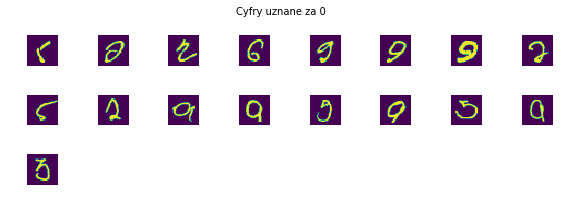

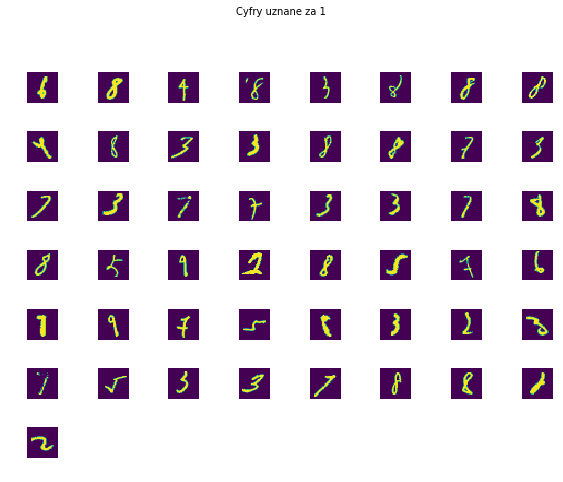

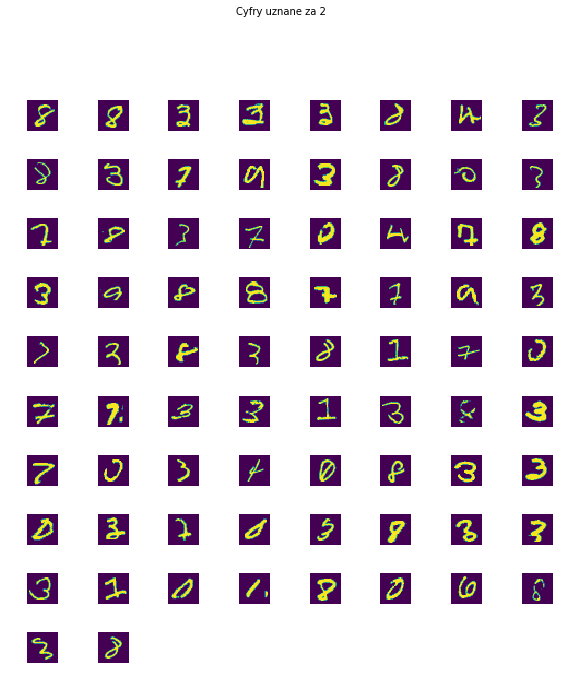

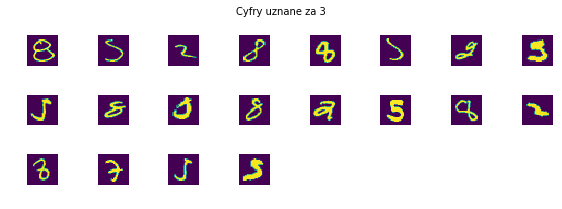

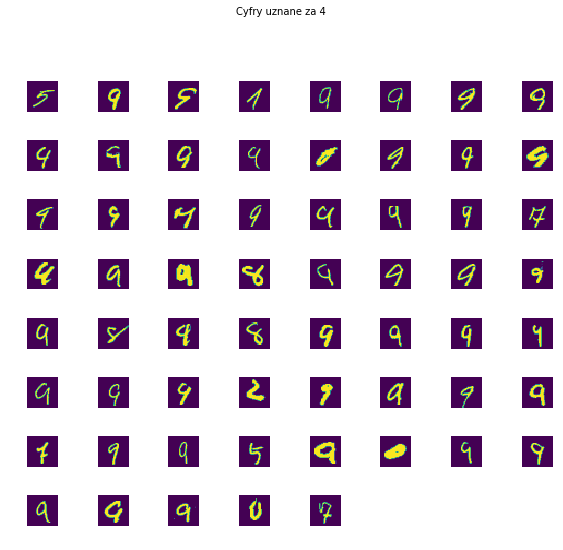

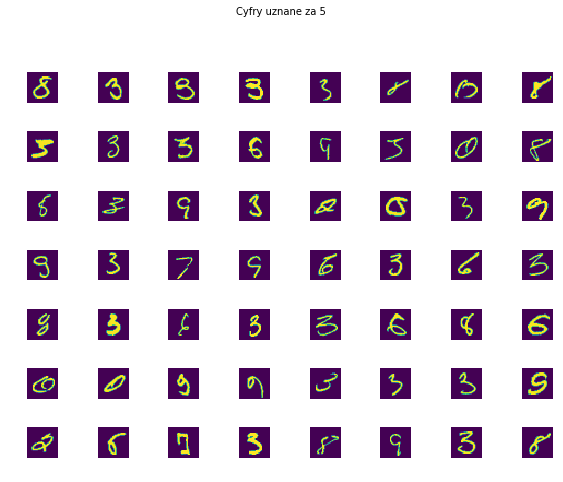

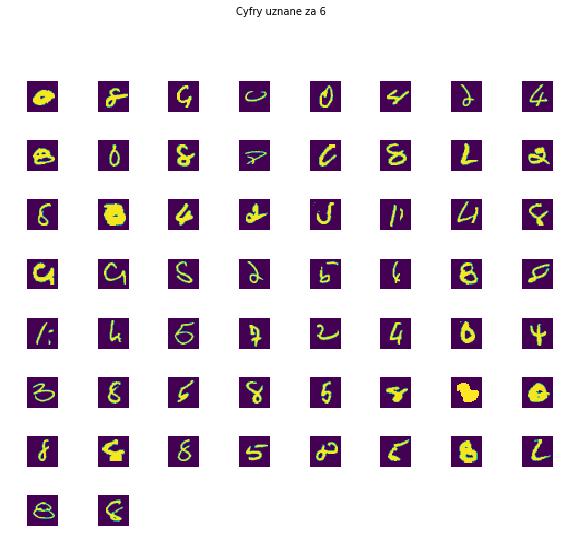

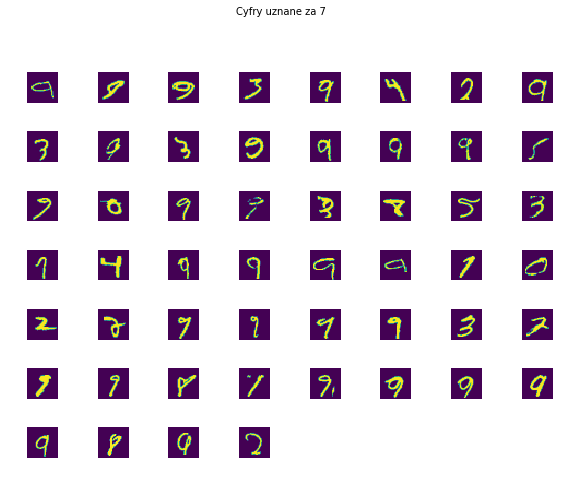

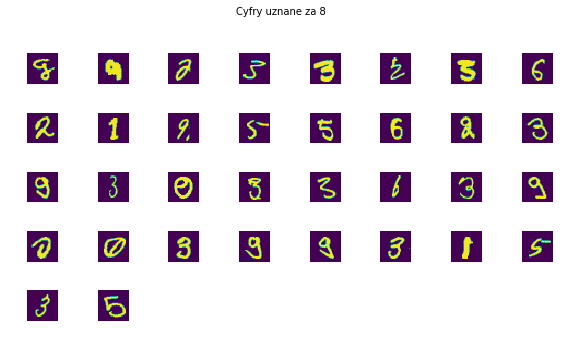

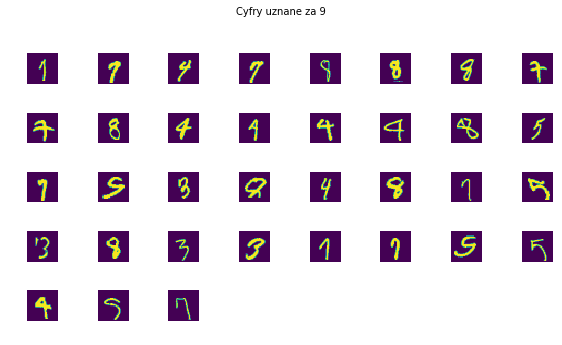

In [14]:
print(f"Train set size:\t{X_train.shape[0]}\nTest set size:\t{X_test.shape[0]}")
print(f"hidden_layers:\t{hidden_layers}\nlayer_size:\t{layer_size}")
print(f"learning_rate:\t{learning_rate}\ninit_type:\t{init_type}\noptimizer:\t{optimizer}\nbatch_size:\t{batch_size}")
print(f"train loss:\t{check_loss(best_network, X_train, y_train)}")
print(f"test loss:\t{check_loss(best_network, X_test, y_test)}")
print(f"accuracy:\t{check_accuracy(best_network, X_test, y_test)}")
confusion_matrix, wrong_list = confusion(best_network, X_test, y_test)
print(f"\n\t\tconfusion matrix:\n\n{confusion_matrix}")
plot_wrong(wrong_list)

### Plot results

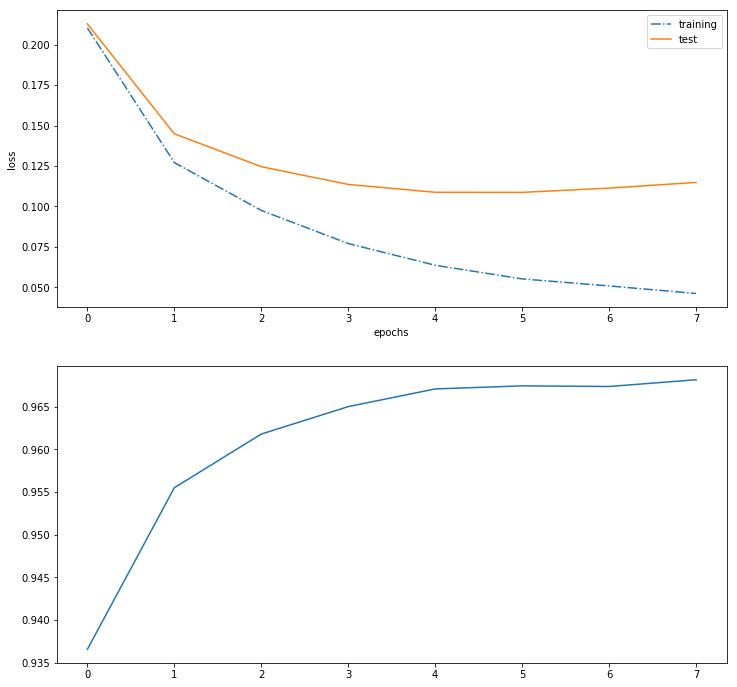

In [15]:
plt.subplots(2,1,figsize=(12,12))
plt.subplot(211)
plt.plot(train_loss_values, linestyle='-.', label='training')
plt.plot(test_loss_values, linestyle='-', label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.subplot(212)
plt.plot(accuracy, linestyle='-', label='training')
plt.show()

## Opis metod użytych do implementacji sieci:

-  Xavier and custom wages normalization
-  Adam optimize algorithm
-  